In [177]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import torch
import easyocr
import imutils
import numpy as np

# Load a model
model = YOLO("best_weights/yolov8n_50_epochs_default_params/best.pt")  # load a pretrained model (recommended for training)
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

In [272]:
def detect_number_plate(img, model, reader):
    import re
    lw = max(round(sum(img.shape) / 2 * 0.003), 2)
    colour = (128, 128, 128)
    txt_colour = (255, 255, 255)
    tf = max(lw - 1, 1)  # font thickness
    sf = lw / 3  # font scale
    
    chars = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)]
    predictions = model(img)
    for prediction in predictions:
        boxes = prediction.boxes
        for box in boxes:
            xyxy = box.xyxy.squeeze()
            x1, y1, x2, y2 = int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3])
            p1, p2 = (x1, y1), (x2, y2)
            h = y2 - y1
            w = x2 - x1
            min_text_size = int(w * 0.25)
            cropped_img = img[y1:y2,x1:x2]
            gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
            plt.imshow(gray)
            extracted_txt = reader.readtext(gray, allowlist=chars, min_size=min_text_size, detail=0, paragraph=True, width_ths=w)
            print(extracted_txt)
            label = ''.join(extracted_txt).strip()
            print(label)
            img = cv2.rectangle(img, p1, p2, colour, thickness=lw, lineType=cv2.LINE_AA)
            
            if label:
                w, h = cv2.getTextSize(label, 0, fontScale=sf, thickness=tf)[0]  # text width, height
                outside = p1[1] - h >= 3
                p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
                img = cv2.rectangle(img, p1, p2, colour, -1, cv2.LINE_AA)  # filled
                img = cv2.putText(img,
                            label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                            0,
                            sf,
                            txt_colour,
                            thickness=tf,
                            lineType=cv2.LINE_AA)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [276]:
image = cv2.imread("datasets/val/images/2bd26c63ebf598b7.jpg")

# result = reader.readtext('chinese.jpg')


0: 512x768 1 number_plate, 7.6ms
Speed: 16.0ms preprocess, 7.6ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 768)


['BNO93']
BNO93


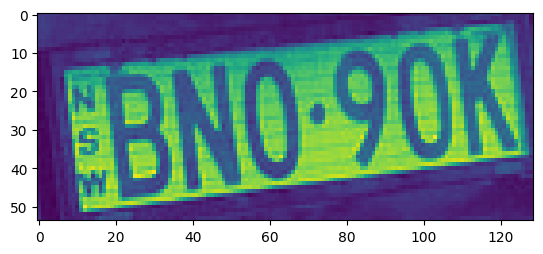

In [277]:
img = detect_number_plate(image, model, reader)

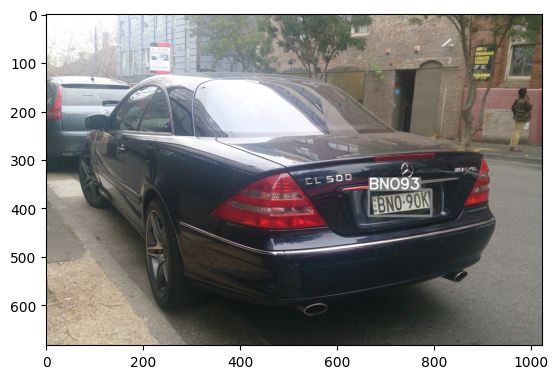

In [278]:
plt.imshow(img)